<a href="https://colab.research.google.com/github/tentenNT/6s_polarization/blob/master/raw_to_polimg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive/')
%ls "drive/My Drive/ColabNotebooks/image_add"
%cd "drive/My Drive/ColabNotebooks/image_add"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ls: cannot access 'drive/My Drive/ColabNotebooks/image_add': No such file or directory
[Errno 2] No such file or directory: 'drive/My Drive/ColabNotebooks/image_add'
/content/drive/My Drive/ColabNotebooks/image_add


In [0]:
# 必要なパッケージのインポート
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# ディレクトリ
dataDir = "./data" # 入力データのディレクトリ
outDir  = "./out"  # 出力データのディレクトリ

# 出力ディレクトリがあるかを確認，なければ作成
if not os.path.exists(outDir):
    os.mkdir(outDir)

# ファイル名
#=======================================
originalInputFileName     = "50mm_raw_kani.avi" # <-- ここを自分で用意した画像に変えること
#=======================================
originalInputFileBaseName, originalInputFileExt = os.path.splitext(originalInputFileName)
resizedInputFileName  = originalInputFileBaseName + '_resized' + originalInputFileExt

# 画像のフルパスの設定（要 os パッケージ）
originalInputFilePath = os.path.join(dataDir, originalInputFileName)
resizedInputFilePath  = os.path.join(outDir, resizedInputFileName)

# 各種パラメータ
#=======================================
resizedWidth = 512 # リサイズ後の画像の幅 [px]
FRAMES = 2
ENTIRE_FRAMES = FRAMES * 2
MEANS = 3
ROW = 1024
COL = 1224
#=======================================



In [0]:
def f_to_uint(img):
  img = np.fix(bg_added)
  img = img.astype('uint8')
  return img

In [0]:
def imshow_resized(img, size=0.2):
  cv2_imshow(cv2.resize(img, None, fx=size, fy=size))

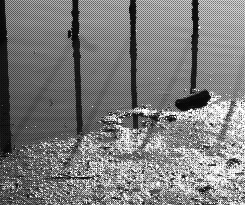

In [50]:
cap = cv2.VideoCapture(originalInputFilePath)
ret, frame = cap.read()
imshow_resized(frame, 0.1)
cap.release()

In [51]:
# avi読み込み
def vread(T=30):
    cap = cv2.VideoCapture(originalInputFilePath)
    ret, frame = cap.read()
    row, col, _ = frame.shape
    image_frames = np.array([])
    for i in range(T):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      if ret:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
          image_frames = np.append(image_frames, frame)
    image_frames =  np.reshape(image_frames, (T, row, col))
    cap.release()
    return image_frames
image_frames = vread(T = ENTIRE_FRAMES)
print(image_frames.shape) # => (例): (21, 600, 600, 3)

(4, 2048, 2448)


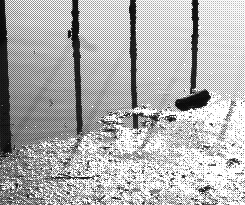

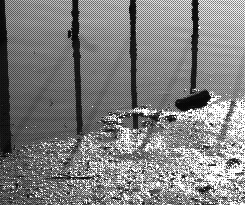

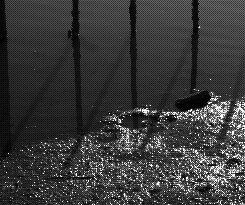

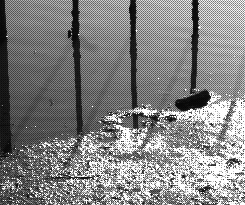

(1024, 1224)
float64


In [52]:
I_90 = image_frames[0,0::2,0::2]
I_45 = image_frames[0, 0::2, 1::2]
I_135 = image_frames[0, 1::2, 0::2]
I_0 = image_frames[0, 1::2, 1::2]
imshow_resized(I_0)
imshow_resized(I_45)
imshow_resized(I_90)
imshow_resized(I_135)

print(I_0.shape)
print(I_0.dtype)

In [0]:
C_1 = I_0 - I_90
C_2 = I_45 - I_135
A = np.power(C_1, 2)
B = np.power(C_2, 2)
R = np.sqrt(A+B)

I_a = R/2
I_b = (I_0+I_45+I_90+I_135)/4
I_max = I_b+I_a
I_min = I_b-I_a
I_max = np.clip(I_max, 0, 255)
I_min = np.clip(I_min, 0, 255)
I_b = np.clip(I_b, 0, 255)

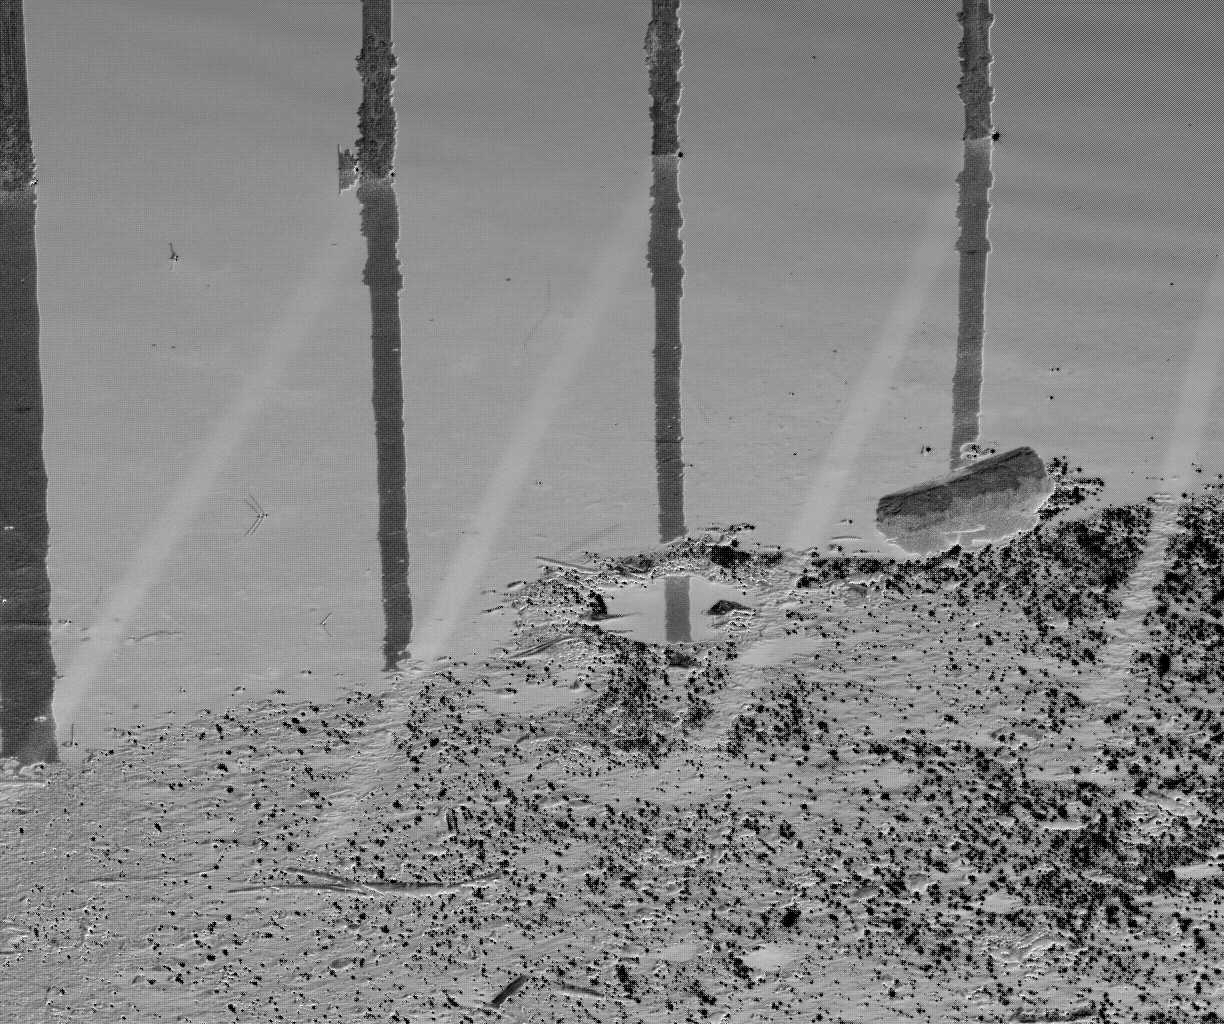

In [55]:
rho = I_a / I_b
imshow_resized(rho*255, 1)